# **Анализ оттока клиентов банка. Kaggle dataset - Churn Modelling**



## Стек: Python(pandas, matplotlib, seaborn). PostgreSQL

## Цели:
## Выявить категории пользователей, склонных к уходу.


## Импорты библиотек. Чтение файла

In [2]:
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Churn_Modelling.csv')

In [3]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Функция для перевода запроса в датафрейм

In [4]:
def pgsql(query):
  return duckdb.query(query).to_df()

## Проверка аномалий

In [ ]:
query_count_customers = '''
    SELECT COUNT(DISTINCT CustomerID) as customers_count,
           COUNT(CustomerID) FILTER (WHERE Balance < 0) as negative_count,
           COUNT(CustomerID) FILTER (WHERE Age <= 0 OR Age > 110) as age_mistakes,
           COUNT(CustomerID) FILTER (WHERE HasCrCard not in ('0', '1') OR IsActiveMember not in ('0', '1')) as bool_mistakes
      FROM df
'''

pgsql(query_count_customers)

,customers_count,negative_count,age_mistakes,bool_mistakes
0,10000,0,0,0


Число записей в базе совпадает с customers_count => нет дублирования CustomerID.
Нет строк с отрицательным балансом.
Нет строк с аномальным возрастом.
Нет строк, имеющих отличные от 0/1 поля HasCrCard,	IsActiveMember.

## Средние значения по странам

In [ ]:
query_avg = '''
    SELECT Geography,
           ROUND(AVG(Balance) FILTER (WHERE Gender = 'Female'), 2) as female_avg_balance,
           ROUND(AVG(Balance) FILTER (WHERE Gender = 'Male'), 2) as male_avg_balance,
           COUNT(CustomerID) FILTER (WHERE Gender = 'Female') as female_count,
           COUNT(CustomerID) FILTER (WHERE Gender = 'Male') as male_count,
           ROUND(AVG(CreditScore) FILTER (WHERE Gender = 'Female'), 2) as female_avg_creditscore,
           ROUND(AVG(CreditScore) FILTER (WHERE Gender = 'Male'), 2) as male_avg_creditscore,
      FROM df
  GROUP BY Geography
'''

pgsql(query_avg)

,Geography,female_avg_balance,male_avg_balance,female_count,male_count,female_avg_creditscore,male_avg_creditscore
0,France,60322.67,63546.28,2261,2753,649.19,650.06
1,Germany,119145.97,120259.67,1193,1316,653.09,649.97
2,Spain,59862.09,63352.83,1089,1388,651.77,650.99


## Сравнение среднего баланса с количеством продуктов

In [20]:
query_balance_NumOfProducts = '''
    SELECT  NumOfProducts,
            MIN(Balance) as min_balance,
            MAX(Balance) as max_balance,
            ROUND(AVG(Balance), 2) as avg_balance,
            ROUND(AVG(Exited), 2) as avg_exited,
            COUNT(Exited) FILTER (WHERE Exited = 1) as count_exited
      FROM df
  GROUP BY NumOfProducts
  ORDER BY 1
'''

pgsql(query_balance_NumOfProducts)

,NumOfProducts,min_balance,max_balance,avg_balance,avg_exited,count_exited
0,1,0.0,238387.56,98551.87,0.28,1409
1,2,0.0,214346.96,51879.15,0.08,348
2,3,0.0,250898.09,75458.33,0.83,220
3,4,0.0,195238.29,93733.14,1.00,60


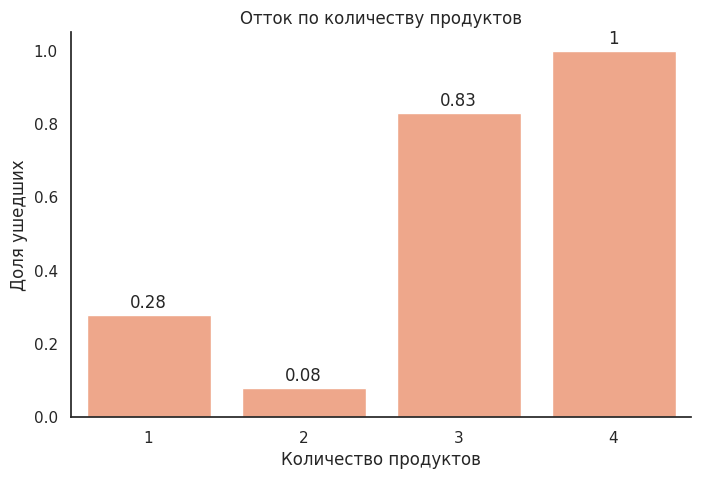

In [21]:
sns.set_theme(style="white")
plt.figure(figsize=(8, 5))

ax = sns.barplot(data=pgsql(query_balance_NumOfProducts), x='NumOfProducts', y='avg_exited', color='lightsalmon')

ax.bar_label(ax.containers[0], padding=2)

plt.title('Отток по количеству продуктов')
plt.ylabel('Доля ушедших')
plt.xlabel('Количество продуктов')
sns.despine()

plt.show()

Клиенты с 3, 4 продуктами уходят в 83, 100 процентах случаев. Минимальный отток среди клиентов с 2 продуктами

## Сегментация оттока по кредитному рейтингу. Отток по странам и возрасту.

In [ ]:
credit_score = '''
    SELECT ROUND(1.0 * COUNT(Exited) FILTER(WHERE CreditScore < 500 ) / COUNT(Exited), 2) as low,
           ROUND(1.0 * COUNT(Exited) FILTER(WHERE CreditScore >= 500 and CreditScore < 700)  / COUNT(Exited), 2) as medium,
           ROUND(1.0 * COUNT(Exited) FILTER(WHERE CreditScore >= 700) / COUNT(Exited), 2) as high

      FROM df
     WHERE Exited = 1
'''
pgsql(credit_score)

,low,medium,high
0,0.07,0.62,0.31


In [6]:
exited = '''
    WITH d AS
   (SELECT Geography,
           COUNT(Exited) FILTER (WHERE Exited = 1) as exited_count,
           ROUND(AVG(Exited), 2) as share_exited,
           ROUND(1.0 * COUNT(Exited) FILTER (WHERE Exited = 1 AND Age > 40) / COUNT(*), 2) as exited_age_above40

      FROM df
  GROUP BY Geography),
  t as (SELECT Balance,
               Exited,
               Geography,
               AVG(Balance) OVER (PARTITION BY Geography) as avg_country_balance
          FROM df),
  f as (SELECT  Geography,
                ROUND(1.0* COUNT(Exited) FILTER (WHERE Exited = 1 AND Balance < avg_country_balance) / COUNT(*), 2)
                as balance_below_avg
          FROM t
          GROUP BY Geography)

  SELECT * FROM f JOIN d USING(Geography)
'''
pgsql(exited)

,Geography,balance_below_avg,exited_count,share_exited,exited_age_above40
0,France,0.07,810,0.16,0.11
1,Germany,0.17,814,0.32,0.22
2,Spain,0.07,413,0.17,0.11


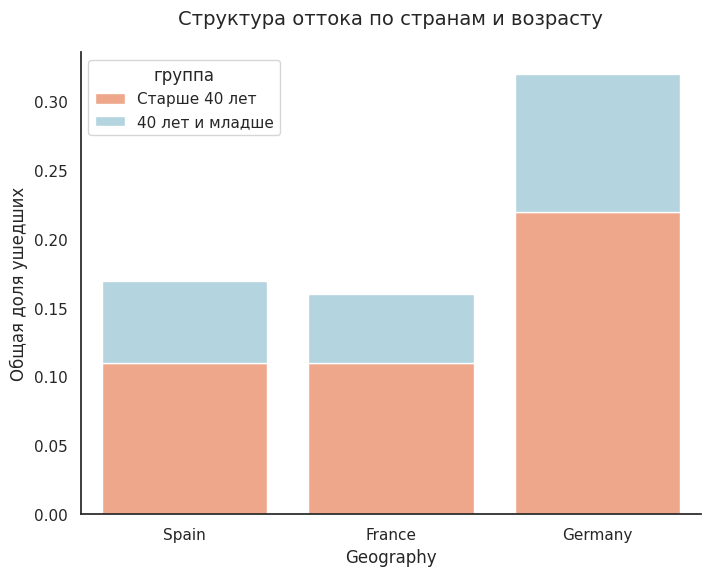

In [14]:
res = pgsql(exited)


res['exited_age_under40'] = res['share_exited'] - res['exited_age_above40']

sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(8, 6))


sns.barplot(data=res,
            x='Geography',
            y='exited_age_above40',
            label='Старше 40 лет',
            color='lightsalmon',
            ax=ax)


sns.barplot(data=res,
            x='Geography',
            y='exited_age_under40',
            bottom=res['exited_age_above40'],
            label='40 лет и младше',
            color='lightblue', ax=ax)


plt.title('Структура оттока по странам и возрасту', fontsize=14, pad=20)
plt.ylabel('Общая доля ушедших')
plt.legend(title='группа')
sns.despine()

plt.show()

В Германии отток в 2 раза больше, чем в Испании и Франции. При этом средний баланс в Германии самый высокий.
В основном отток наблюдается среди клиентов возраста старше 40.

## Корреляция. Пирсон

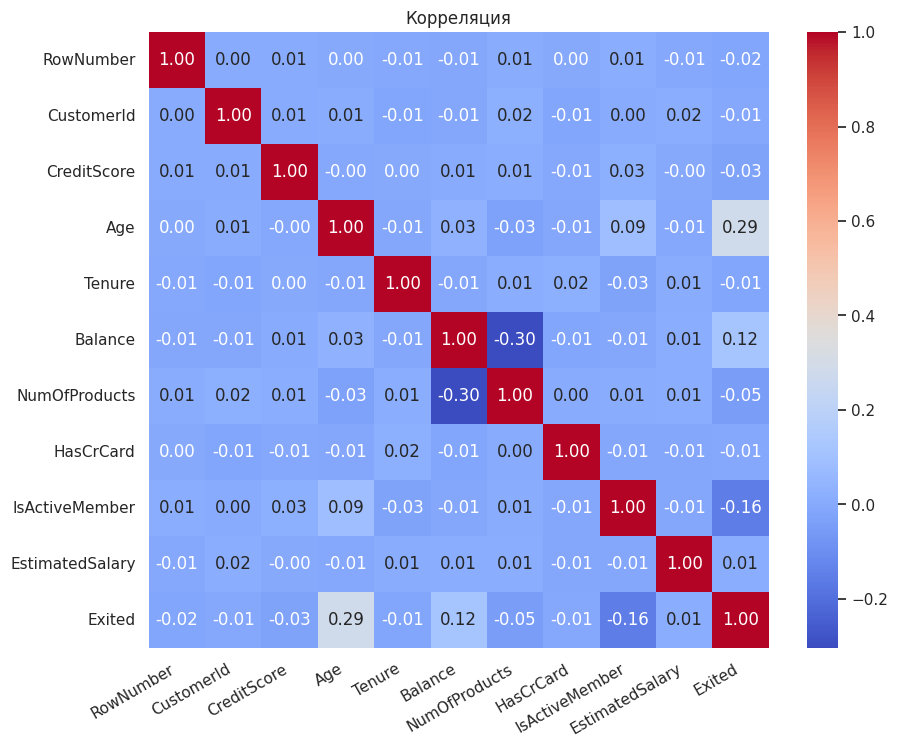

In [26]:
numeric_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation = 30, ha = 'right')
plt.title('Корреляция')
plt.show()

Существует прямая связь между уходом и возрастом, обратная между уходом и активностью.
Слабая связь между уходом и балансом.
Слабая связь между уходом и количеством продуктов.
Остальные признаки не влияют на отток.

## Корреляция. Спирмен

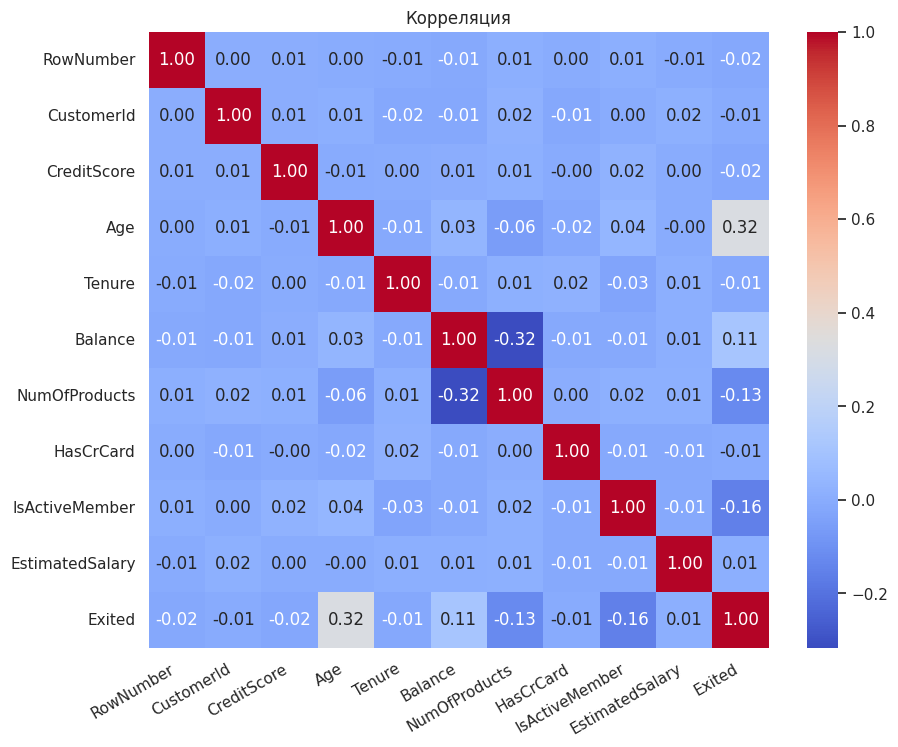

In [22]:
numeric_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[numeric_cols].corr(method = 'spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation = 30, ha = 'right')
plt.title('Корреляция')
plt.show()

Выявлена нелинейная обратная связь между уходом и количеством продуктов.

## Корреляция. Кендалл

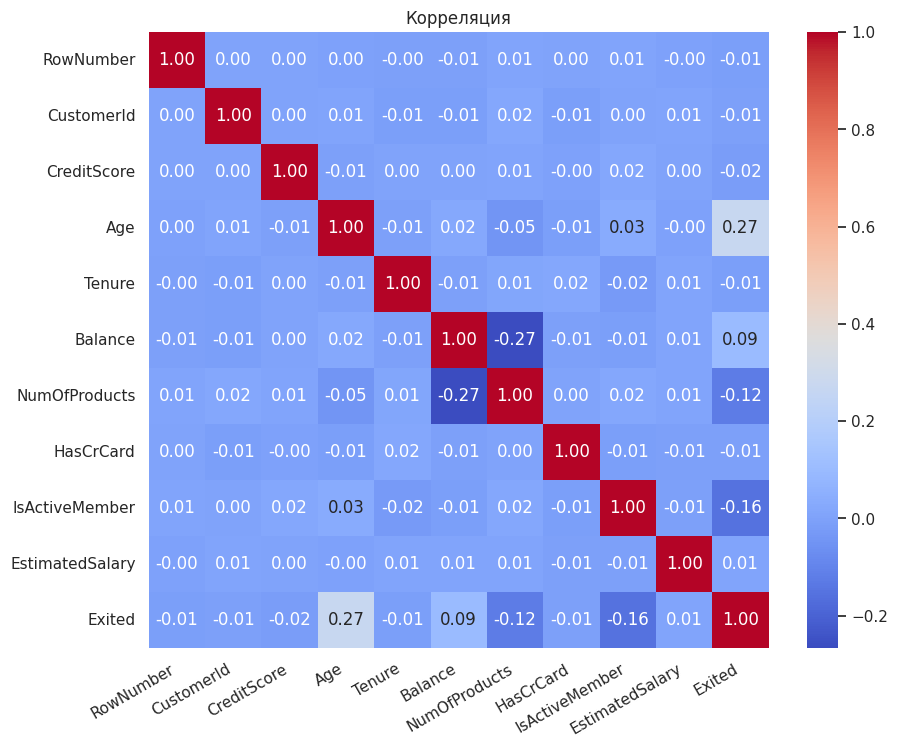

In [23]:
numeric_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[numeric_cols].corr(method = 'kendall')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation = 30, ha = 'right')
plt.title('Корреляция')
plt.show()

Использование коэффициентов Спирмена и Кендалла позволило подтвердить нелинейную зависимость между количеством продуктов и оттоком, которую не зафиксировал метод Пирсона.